## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import gmsh
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import scipy
import time
from multiprocessing import Pool
import gc
from gmsh_util import create_normal_mesh,create_box_mesh, read_mesh
from matplotlib.path import Path

## Validation of quasi-static solver code 
### (using a variable mesh as prescribed in literature)

In [9]:
from worker_rect import picard_helper_rect
from quasi_static_util import quasi_static_fem, quasi_static_picard

In [ ]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all = 1,
                                msf_adapt=0.5,
                                side = 6,
                                x_s=50,
                                y_s=25,
                                is_adapt=True
                                )

In [ ]:
# No source
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
h,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "no_source",verbose = False)
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f}C and the minimum temperature is {np.min(theta):.2f} C")

In [ ]:
#Source with physical properties not being a function of temperature
soln_qs = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
_,K,G,F,boundary,theta = soln_qs.fit_ele(mode = "linear",verbose = False)
# h,K,G,F,boundary_term,theta
gc.collect()
plt.figure(figsize=(8,4))
plt.tricontourf(nodecoords[:,0],nodecoords[:,1],theta.flatten(),cmap = 'jet')
plt.colorbar()
plt.show()

In [ ]:
gc.collect()

In [ ]:
print(f"The maximum temperature is {np.max(theta):.2f} K and the minimum temperature is {np.min(theta):.2f} K")

## Validation of picard iteration

In [26]:
from picard_valid_util import picard_sq, picard_iterative_sq

In [ ]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                msf_all=mesh_size_factor) 
soln3 = picard_sq(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = picard_iterative_sq(soln3,nodecoords,ele_con,theta_init)

In [ ]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

In [ ]:
gc.collect()

## Newton Raphson validation

In [2]:
from nr_valid_util import nr_sq, nr_iterative_sq

In [ ]:
mesh_size_factor = 3
filename = f"square_{mesh_size_factor}.msh"
nodecoords,ele_con = createMesh(geo_file='squareDomain.geo',
                                msf_all=mesh_size_factor) 
soln3 = nr_sq(nodecoords,ele_con)
T_b = 273+50
theta_init = np.zeros((nodecoords.shape[0],1))+T_b
theta_final = nr_iterative_sq(soln3,nodecoords,ele_con,theta_init)

In [ ]:
Ta = theta_final[np.where((nodecoords[:,0] == 0) * (nodecoords[:,1] == 100)) [0][0]]-273
Tb = theta_final[np.where((nodecoords[:,0] == 100) * (nodecoords[:,1] == 100)) [0][0]]-273
print(f"The temperature at node a is {Ta[0]:.2f}K and at node b is {Tb[0]:.2f}K")

## Newton raphson implementation

In [2]:
from transient_util import nr_iterative_rect

In [3]:
def find_triangle_params(rep,nodecoords,ele_con):
    rep_x,rep_y,rep_z = rep[0,0],rep[0,1],rep[0,2]
    all_x,all_y,all_z = nodecoords[:,0],nodecoords[:,1],nodecoords[:,2]
    # params = np.zeros((ele_con.shape[0],2))
    for i,elei in enumerate(ele_con):
        econ = elei-1
        boundary = nodecoords[np.ix_(econ,[0,1])]
        dN = np.array([[-1,1,0],[-1,0,1]])
        Jac = np.matmul(dN,boundary)
        if np.linalg.det(Jac)<0:
            econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
            boundary = nodecoords[np.ix_(econ,[0,1])] 
            Jac = np.matmul(dN,boundary)

        triangle = Path(boundary)
        if triangle.contains_point(np.array([rep_x,rep_y]),radius = 1e-9):
            v1,v2,v3 = econ[0],econ[1],econ[2]
            A = np.array([[all_x[v2]-all_x[v1],all_x[v3]-all_x[v1]],[all_y[v2]-all_y[v1],all_y[v3]-all_y[v1]]])
            B = np.array([[rep_x-all_x[v1]],[rep_y-all_y[v1]]])
            params = (np.linalg.inv(A)@B)
            return econ,params[0,0],params[1,0]
    print("Triangle not found")
    return -1

### Mesh convergence for static problem

In [ ]:
gc.collect()

In [ ]:
## now find fine mesh size
msf_all = 5
msfs_adapt = np.arange(5,0.4,-0.25)
T_l = 20
rep = np.array([[48,25,0]])
mesh_sizes = []
n_eles = []
T_reps = []

for msf_adapt in msfs_adapt:
    nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                    msf_all=msf_all,
                                    msf_adapt = msf_adapt,
                                    length = 100,
                                    width = 8,
                                    x_s = 50,
                                    y_s = 25) 
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    h,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]]),theta_init,type = "static",mode = "non_linear")
    mesh_sizes.append(h)
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])
    n_eles.append(len(ele_con))

In [ ]:
plt.plot(mesh_sizes,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh sizes (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [45]:
T_reps = [ele[0][0] for ele in T_reps]

In [ ]:
plt.plot(n_eles,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Number of elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
gc.collect()

In [ ]:
## now find fine mesh size
converged_msf_adapt = 1.5
msfs = np.arange(10,1.5,-1)
T_l = 20
rep = np.array([[48,40,0]])
mesh_sizes = []
n_eles = []
T_reps = []

for msf in msfs:
    nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                    msf_all=msf,
                                    msf_adapt = converged_msf_adapt,
                                    length = 100,
                                    width = 8,
                                    x_s = 50,
                                    y_s = 25) 
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    h,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]]),theta_init,type = "static",mode = "non_linear")
    mesh_sizes.append(h)
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])
    n_eles.append(len(ele_con))

In [ ]:
plt.plot(mesh_sizes,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh sizes (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
plt.plot(n_eles,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Number of elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

### Temporal convergence

Reading reqd_mesh.msh
Number of nodes in the mesh: 1100
Number of triangles in the mesh: 2086

Error at 1 iteration at time 0.0 is 3.70E+02
Error at 2 iteration at time 0.0 is 2.12E+01
Error at 3 iteration at time 0.0 is 1.10E+00
Error at 4 iteration at time 0.0 is 5.54E-02
Error at 5 iteration at time 0.0 is 2.72E-03
Error at 1 iteration at time 0.1 is 3.16E+02
Error at 2 iteration at time 0.1 is 1.76E+01
Error at 3 iteration at time 0.1 is 8.70E-01
Error at 4 iteration at time 0.1 is 3.92E-02
Error at 5 iteration at time 0.1 is 1.66E-03
Error at 1 iteration at time 0.2 is 2.79E+02
Error at 2 iteration at time 0.2 is 1.49E+01
Error at 3 iteration at time 0.2 is 7.10E-01
Error at 4 iteration at time 0.2 is 2.87E-02
Error at 5 iteration at time 0.2 is 1.02E-03
Error at 1 iteration at time 0.30000000000000004 is 2.54E+02
Error at 2 iteration at time 0.30000000000000004 is 1.29E+01
Error at 3 iteration at time 0.30000000000000004 is 5.97E-01
Error at 4 iteration at time 0.3000000000000000

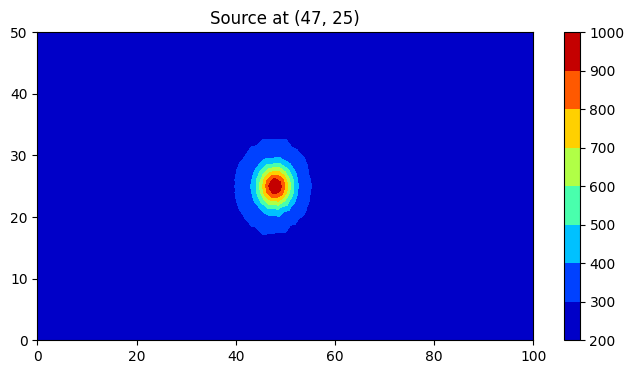

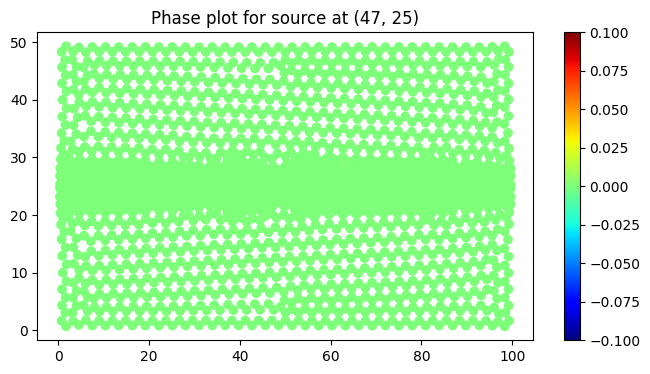

Error at 1 iteration at time 0.0 is 4.06E+02
Error at 2 iteration at time 0.0 is 2.54E+01
Error at 3 iteration at time 0.0 is 1.41E+00
Error at 4 iteration at time 0.0 is 7.57E-02
Error at 5 iteration at time 0.0 is 3.97E-03
Error at 1 iteration at time 0.1111111111111111 is 3.42E+02
Error at 2 iteration at time 0.1111111111111111 is 2.05E+01
Error at 3 iteration at time 0.1111111111111111 is 1.08E+00
Error at 4 iteration at time 0.1111111111111111 is 5.13E-02
Error at 5 iteration at time 0.1111111111111111 is 2.27E-03
Error at 1 iteration at time 0.2222222222222222 is 3.01E+02
Error at 2 iteration at time 0.2222222222222222 is 1.71E+01
Error at 3 iteration at time 0.2222222222222222 is 8.65E-01
Error at 4 iteration at time 0.2222222222222222 is 3.66E-02
Error at 5 iteration at time 0.2222222222222222 is 1.33E-03
Error at 1 iteration at time 0.3333333333333333 is 2.73E+02
Error at 2 iteration at time 0.3333333333333333 is 1.47E+01
Error at 3 iteration at time 0.3333333333333333 is 7.17

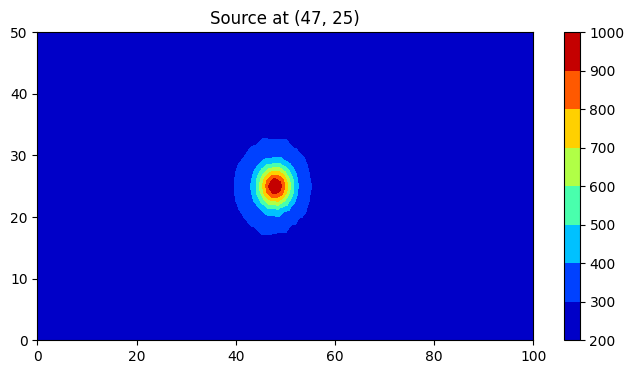

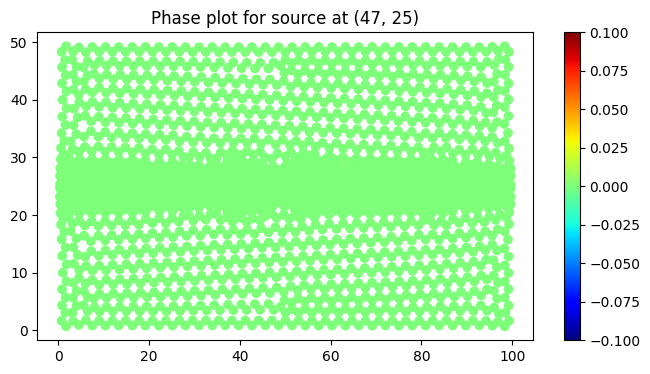

Error at 1 iteration at time 0.0 is 4.49E+02
Error at 2 iteration at time 0.0 is 3.09E+01
Error at 3 iteration at time 0.0 is 1.84E+00
Error at 4 iteration at time 0.0 is 1.06E-01
Error at 5 iteration at time 0.0 is 5.99E-03
Error at 1 iteration at time 0.125 is 3.75E+02
Error at 2 iteration at time 0.125 is 2.43E+01
Error at 3 iteration at time 0.125 is 1.36E+00
Error at 4 iteration at time 0.125 is 6.83E-02
Error at 5 iteration at time 0.125 is 3.18E-03
Error at 1 iteration at time 0.25 is 3.27E+02
Error at 2 iteration at time 0.25 is 2.00E+01
Error at 3 iteration at time 0.25 is 1.07E+00
Error at 4 iteration at time 0.25 is 4.74E-02
Error at 5 iteration at time 0.25 is 1.78E-03
Error at 1 iteration at time 0.375 is 2.96E+02
Error at 2 iteration at time 0.375 is 1.70E+01
Error at 3 iteration at time 0.375 is 8.74E-01
Error at 4 iteration at time 0.375 is 3.60E-02
Error at 5 iteration at time 0.375 is 1.16E-03
Error at 1 iteration at time 0.5 is 2.76E+02
Error at 2 iteration at time 0

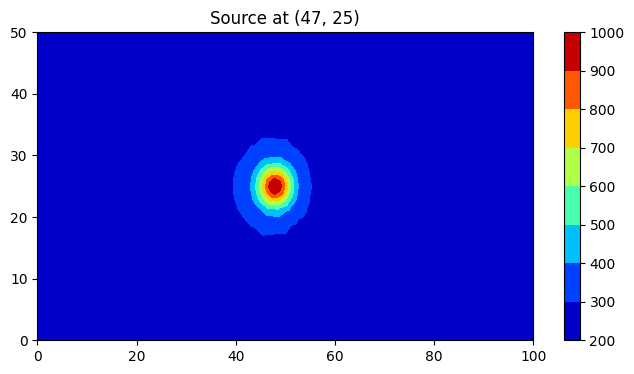

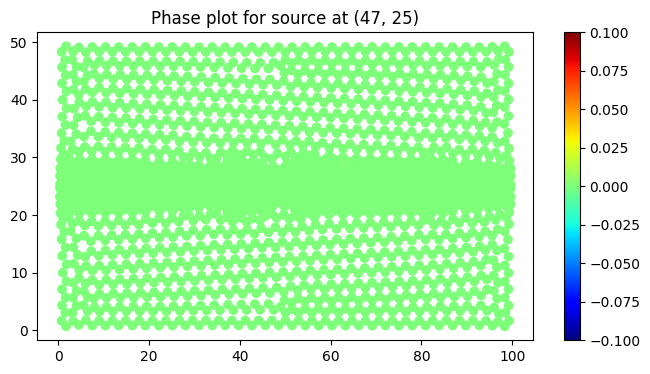

Error at 1 iteration at time 0.0 is 5.04E+02
Error at 2 iteration at time 0.0 is 3.83E+01
Error at 3 iteration at time 0.0 is 2.48E+00
Error at 4 iteration at time 0.0 is 1.55E-01
Error at 5 iteration at time 0.0 is 9.40E-03
Error at 1 iteration at time 0.14285714285714285 is 4.14E+02
Error at 2 iteration at time 0.14285714285714285 is 2.93E+01
Error at 3 iteration at time 0.14285714285714285 is 1.76E+00
Error at 4 iteration at time 0.14285714285714285 is 9.33E-02
Error at 5 iteration at time 0.14285714285714285 is 4.56E-03
Error at 1 iteration at time 0.2857142857142857 is 3.60E+02
Error at 2 iteration at time 0.2857142857142857 is 2.37E+01
Error at 3 iteration at time 0.2857142857142857 is 1.34E+00
Error at 4 iteration at time 0.2857142857142857 is 6.27E-02
Error at 5 iteration at time 0.2857142857142857 is 2.44E-03
Error at 1 iteration at time 0.42857142857142855 is 3.25E+02
Error at 2 iteration at time 0.42857142857142855 is 1.99E+01
Error at 3 iteration at time 0.42857142857142855

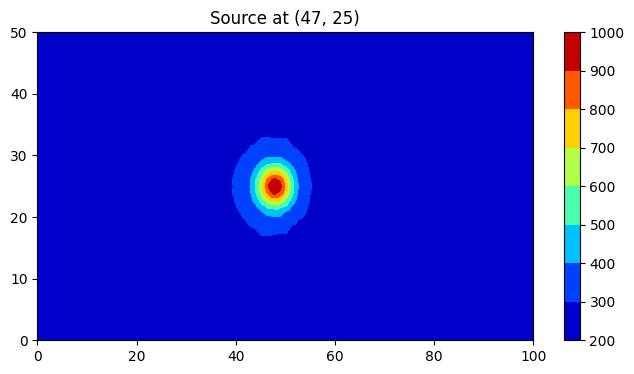

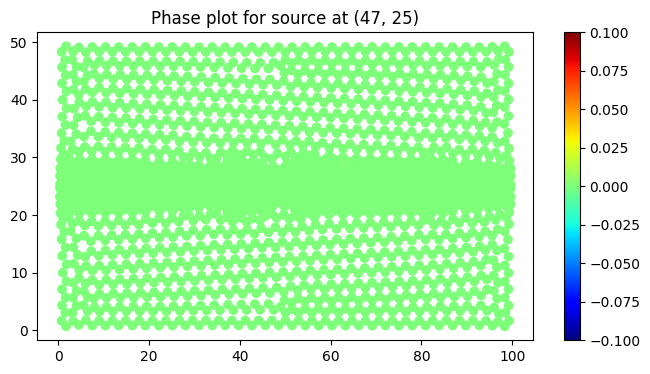

Error at 1 iteration at time 0.0 is 5.74E+02
Error at 2 iteration at time 0.0 is 4.90E+01
Error at 3 iteration at time 0.0 is 3.44E+00
Error at 4 iteration at time 0.0 is 2.34E-01
Error at 5 iteration at time 0.0 is 1.55E-02
Error at 6 iteration at time 0.0 is 1.02E-03
Error at 1 iteration at time 0.16666666666666666 is 4.63E+02
Error at 2 iteration at time 0.16666666666666666 is 3.60E+01
Error at 3 iteration at time 0.16666666666666666 is 2.32E+00
Error at 4 iteration at time 0.16666666666666666 is 1.31E-01
Error at 5 iteration at time 0.16666666666666666 is 6.75E-03
Error at 1 iteration at time 0.3333333333333333 is 4.00E+02
Error at 2 iteration at time 0.3333333333333333 is 2.85E+01
Error at 3 iteration at time 0.3333333333333333 is 1.73E+00
Error at 4 iteration at time 0.3333333333333333 is 8.50E-02
Error at 5 iteration at time 0.3333333333333333 is 3.42E-03
Error at 1 iteration at time 0.5 is 3.63E+02
Error at 2 iteration at time 0.5 is 2.38E+01
Error at 3 iteration at time 0.5 is

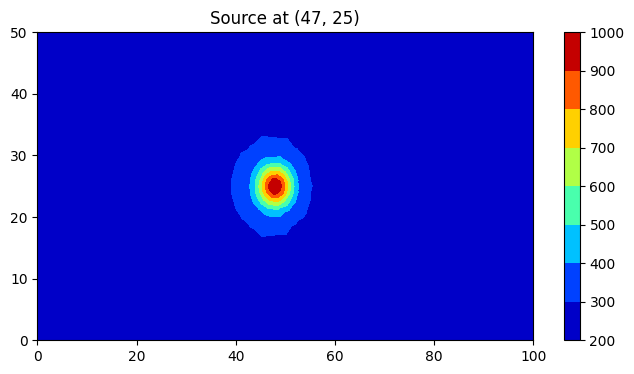

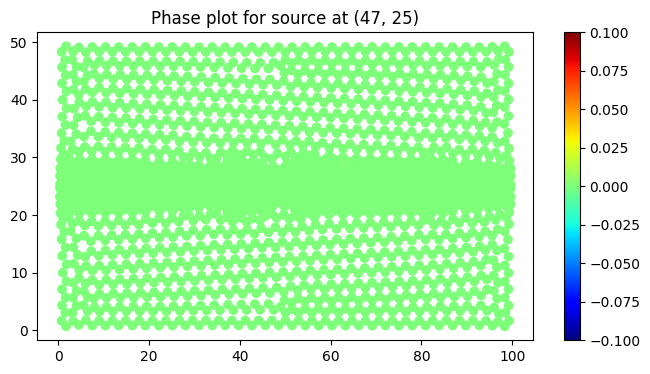

Error at 1 iteration at time 0.0 is 6.68E+02
Error at 2 iteration at time 0.0 is 6.48E+01
Error at 3 iteration at time 0.0 is 5.00E+00
Error at 4 iteration at time 0.0 is 3.73E-01
Error at 5 iteration at time 0.0 is 2.71E-02
Error at 6 iteration at time 0.0 is 1.95E-03
Error at 1 iteration at time 0.2 is 5.28E+02
Error at 2 iteration at time 0.2 is 4.55E+01
Error at 3 iteration at time 0.2 is 3.17E+00
Error at 4 iteration at time 0.2 is 1.91E-01
Error at 5 iteration at time 0.2 is 1.04E-02
Error at 6 iteration at time 0.2 is 5.38E-04
Error at 1 iteration at time 0.4 is 4.54E+02
Error at 2 iteration at time 0.4 is 3.52E+01
Error at 3 iteration at time 0.4 is 2.28E+00
Error at 4 iteration at time 0.4 is 1.19E-01
Error at 5 iteration at time 0.4 is 4.99E-03
Error at 1 iteration at time 0.6000000000000001 is 4.13E+02
Error at 2 iteration at time 0.6000000000000001 is 2.91E+01
Error at 3 iteration at time 0.6000000000000001 is 1.79E+00
Error at 4 iteration at time 0.6000000000000001 is 8.73

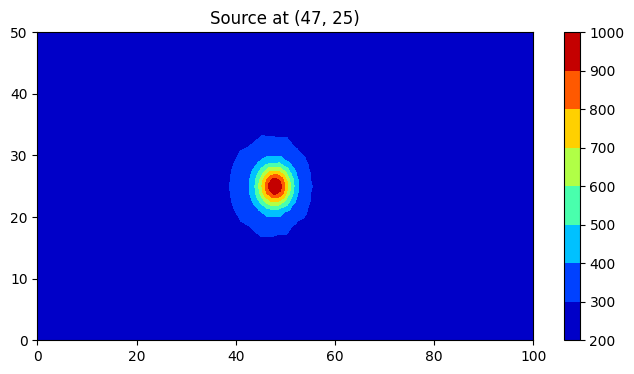

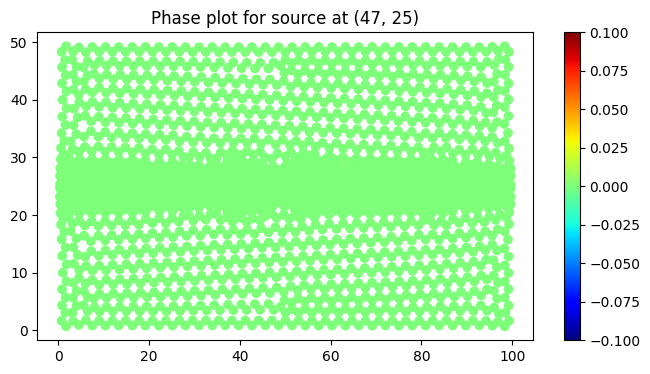

Error at 1 iteration at time 0.0 is 8.00E+02
Error at 2 iteration at time 0.0 is 8.99E+01
Error at 3 iteration at time 0.0 is 7.69E+00
Error at 4 iteration at time 0.0 is 6.38E-01
Error at 5 iteration at time 0.0 is 5.14E-02
Error at 6 iteration at time 0.0 is 4.10E-03
Error at 1 iteration at time 0.25 is 6.17E+02
Error at 2 iteration at time 0.25 is 5.95E+01
Error at 3 iteration at time 0.25 is 4.50E+00
Error at 4 iteration at time 0.25 is 2.91E-01
Error at 5 iteration at time 0.25 is 1.67E-02
Error at 6 iteration at time 0.25 is 9.09E-04
Error at 1 iteration at time 0.5 is 5.30E+02
Error at 2 iteration at time 0.5 is 4.49E+01
Error at 3 iteration at time 0.5 is 3.13E+00
Error at 4 iteration at time 0.5 is 1.75E-01
Error at 5 iteration at time 0.5 is 7.74E-03
Error at 1 iteration at time 0.75 is 4.88E+02
Error at 2 iteration at time 0.75 is 3.67E+01
Error at 3 iteration at time 0.75 is 2.46E+00
Error at 4 iteration at time 0.75 is 1.32E-01
Error at 5 iteration at time 0.75 is 5.48E-03

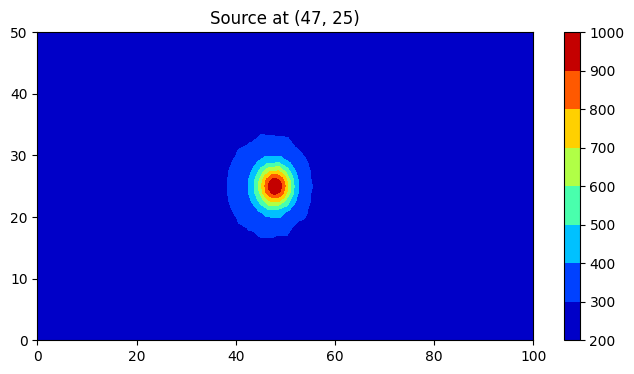

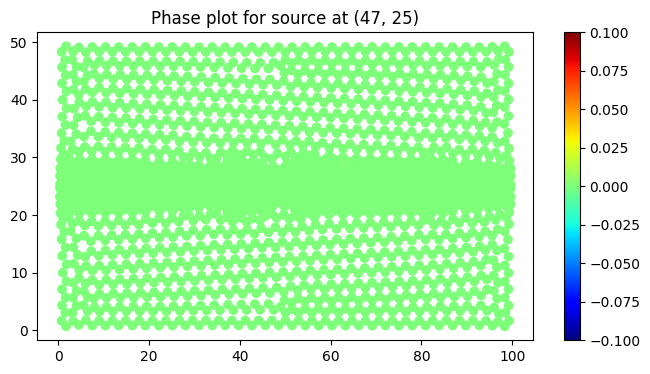

Error at 1 iteration at time 0.0 is 1.00E+03
Error at 2 iteration at time 0.0 is 1.34E+02
Error at 3 iteration at time 0.0 is 1.28E+01
Error at 4 iteration at time 0.0 is 1.19E+00
Error at 5 iteration at time 0.0 is 1.08E-01
Error at 6 iteration at time 0.0 is 9.69E-03
Error at 1 iteration at time 0.3333333333333333 is 7.50E+02
Error at 2 iteration at time 0.3333333333333333 is 8.17E+01
Error at 3 iteration at time 0.3333333333333333 is 6.75E+00
Error at 4 iteration at time 0.3333333333333333 is 4.72E-01
Error at 5 iteration at time 0.3333333333333333 is 2.87E-02
Error at 6 iteration at time 0.3333333333333333 is 1.65E-03
Error at 1 iteration at time 0.6666666666666666 is 6.50E+02
Error at 2 iteration at time 0.6666666666666666 is 6.00E+01
Error at 3 iteration at time 0.6666666666666666 is 4.63E+00
Error at 4 iteration at time 0.6666666666666666 is 2.89E-01
Error at 5 iteration at time 0.6666666666666666 is 1.45E-02
Error at 6 iteration at time 0.6666666666666666 is 6.11E-04
Error at 1

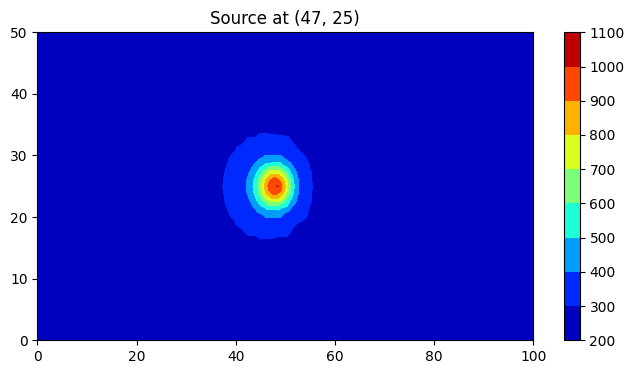

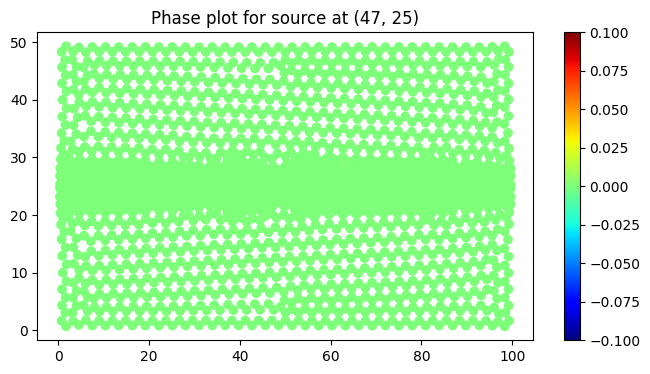

Error at 1 iteration at time 0.0 is 1.35E+03
Error at 2 iteration at time 0.0 is 2.23E+02
Error at 3 iteration at time 0.0 is 2.42E+01
Error at 4 iteration at time 0.0 is 2.56E+00
Error at 5 iteration at time 0.0 is 2.63E-01
Error at 6 iteration at time 0.0 is 2.69E-02
Error at 7 iteration at time 0.0 is 2.76E-03
Error at 1 iteration at time 0.5 is 9.85E+02
Error at 2 iteration at time 0.5 is 1.22E+02
Error at 3 iteration at time 0.5 is 1.13E+01
Error at 4 iteration at time 0.5 is 8.90E-01
Error at 5 iteration at time 0.5 is 6.12E-02
Error at 6 iteration at time 0.5 is 4.01E-03
Error at 1 iteration at time 1.0 is 8.86E+02
Error at 2 iteration at time 1.0 is 8.81E+01
Error at 3 iteration at time 1.0 is 8.08E+00
Error at 4 iteration at time 1.0 is 6.52E-01
Error at 5 iteration at time 1.0 is 4.71E-02
Error at 6 iteration at time 1.0 is 3.28E-03


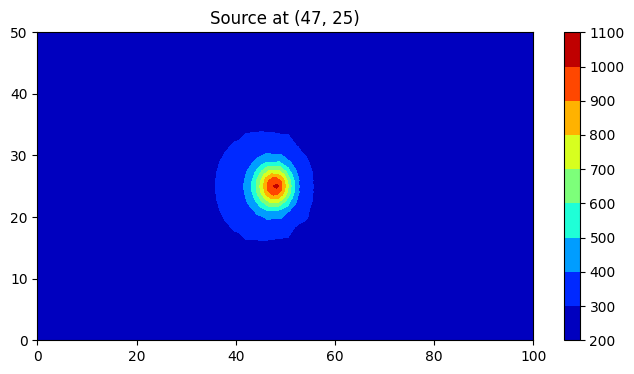

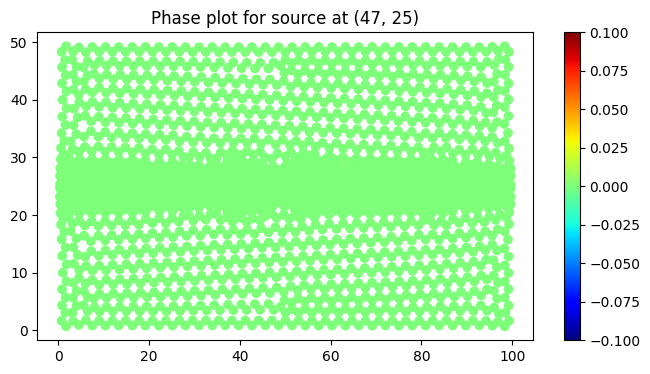

Error at 1 iteration at time 0.0 is 2.16E+03
Error at 2 iteration at time 0.0 is 4.71E+02
Error at 3 iteration at time 0.0 is 6.02E+01
Error at 4 iteration at time 0.0 is 7.40E+00
Error at 5 iteration at time 0.0 is 8.71E-01
Error at 6 iteration at time 0.0 is 1.03E-01
Error at 7 iteration at time 0.0 is 1.22E-02
Error at 8 iteration at time 0.0 is 1.45E-03
Error at 1 iteration at time 1.0 is 1.61E+03
Error at 2 iteration at time 1.0 is 2.21E+02
Error at 3 iteration at time 1.0 is 2.67E+01
Error at 4 iteration at time 1.0 is 3.23E+00
Error at 5 iteration at time 1.0 is 3.89E-01
Error at 6 iteration at time 1.0 is 4.72E-02
Error at 7 iteration at time 1.0 is 5.78E-03


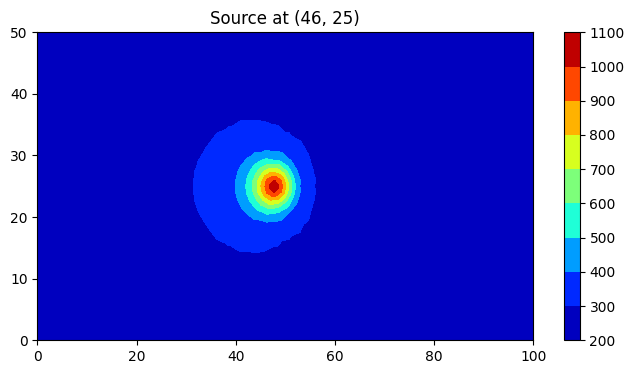

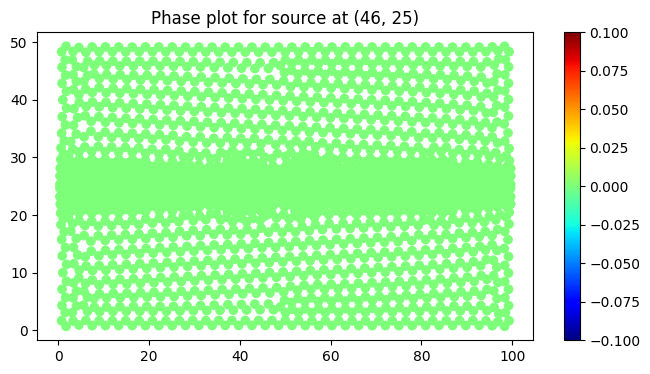

In [10]:
iters = np.arange(10,0,-1)
# iters = 1
converged_msf = 3
converged_msf_adapt = 1.5
T_l = 20+273
rep = np.array([[50,25,0]]).reshape(1,-1)
mesh_sizes = []
n_eles = []
T_reps = []
t_final = 1
nodecoords,ele_con = create_box_mesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt = converged_msf_adapt,
                                length = 100,
                                width = 8,
                                x_s = 50,
                                y_s = 25) 
for iter in iters:
    dt = t_final/iter
    theta_init = np.zeros((nodecoords.shape[0],1))+T_l
    _,theta_fin = nr_iterative_rect(nodecoords,ele_con,np.array([[50,25]],dtype = np.float32),theta_init,dt = dt,t_final =t_final+1e-3,type = "transient",mode = "phase_change")
    econ,eeta,zeta = find_triangle_params(rep,nodecoords,ele_con)
    N = np.array([[1-eeta-zeta,eeta,zeta]])
    T_reps.append((N@theta_fin[np.ix_(econ,[0])])[0][0])

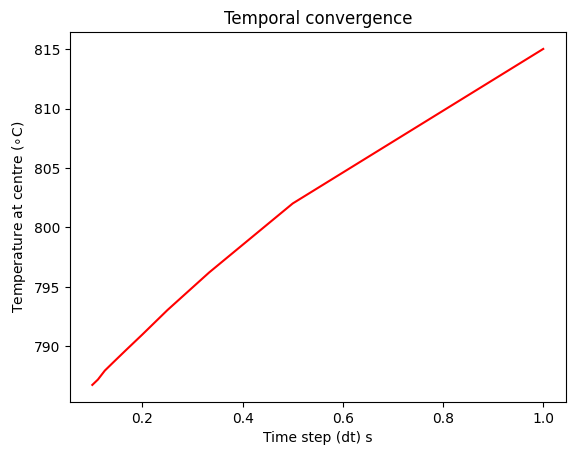

In [11]:
plt.plot(t_final/iters,T_reps,'r')
plt.title('Temporal convergence')
plt.xlabel('Time step (dt) s')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

## Adaptive meshing

### Mesh convergence

In [ ]:
# Finding mesh size factor for the adaptive mesh part
mesh_size_factor = 3
area_patch = 12 * 12
area_all = 100*50
msf_patch_all = np.arange(0.1,0.2,0.01)
h_patch = []
h = []
for msf_patch in msf_patch_all:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    nodes_patch = np.where((np.max(nodecoords[ele_con-1][:,:,0],axis=1)<56)*(np.min(nodecoords[ele_con-1][:,:,0],axis=1)>44)*(np.max(nodecoords[ele_con-1][:,:,1],axis=1)<31)*(np.min(nodecoords[ele_con-1][:,:,1],axis=1)>19))[0]
    h_patch.append((area_patch / len(nodes_patch))**.5)
    h.append((area_all/ len(nodecoords))**.5)

In [ ]:
plt.plot(msf_patch_all,h_patch,'r')
plt.xlabel('Mesh Size Factor')
plt.ylabel('Value of h_patch (mm)')
plt.title('Plot of $h$ v/s Mesh Size Factor (for source term only)')
plt.show()

In [ ]:
print(f'Value of h for mesh size factor 0.15 is '+str(h_patch[5]))

In [ ]:
gc.collect()

In [ ]:
# mesh convergence for the coarser part given that for finer the factor is 0.15
mesh_size_factors = np.array([1]+ np.arange(5,50,5).tolist())
converged_msf_patch = 0.15

#representative point
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                        msf_all=mesh_size_factor,
                                        msf_adapt=converged_msf_patch,
                                        side = 12,
                                        x_s=50,
                                        y_s=25,
                                        is_adapt=True
                                    )
    soln_qs_p = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln_qs_p.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements (mm)')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
x = np.log(mesh_size_factors[2:])
y = np.log(T_reps[2:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [ ]:
gc.collect()

## Final solution

In [ ]:
# Final solution for Titanium alloy with assumed properties and no physical modelling
T_l = 273+500
vo = 2 #mm/s
t_final = 10
times = [12.5,25,37.5]
converged_msf = 1
x_source = 100
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=converged_msf,
                                msf_adapt=converged_msf_patch,
                                side = 12,
                                x_s=x_source-times[0]*vo,
                                y_s=25,
                                is_adapt=True)

theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
for i,t in enumerate(times):
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*t,
                                    y_s=25,
                                    is_adapt=True
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]))
    nodecoords,_ = createMesh(geo_file='rectangle.geo',
                                    msf_all=converged_msf,
                                    msf_adapt=converged_msf_patch,
                                    side = 12,
                                    x_s=x_source-vo*(times[i+1] if i+1 < len(times) else 0),
                                    y_s=25,
                                    is_adapt=True
                                )
    theta_prev = np.zeros((nodecoords.shape[0],1))+T_l

In [ ]:
# Normal mesh convergence for phase change consideration of Titanium alloy

mesh_size_factors = np.array(np.arange(1.5,2,0.1).tolist() + np.arange(3,10,1).tolist())
rep = np.array([50,25,0]).reshape(1,-1)
mesh_sizes = []
T_reps = []
n_ele = []
for mesh_size_factor in mesh_size_factors:
    print(mesh_size_factor)
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=mesh_size_factor,
                                )
    soln1 = quasi_static_fem(nodecoords,ele_con,np.array([[50,25]]))
    h,K,G,F,boundary,theta = soln1.fit_ele(mode = "linear",verbose = False)
    mesh_sizes.append(h)

    distances = np.sum(np.square(nodecoords-rep),axis = 1)
    closest = np.argmin(distances)
    T_reps.append(theta[closest])
    n_ele.append(len(ele_con))

plt.plot(mesh_size_factors,T_reps,'r')
plt.title('Mesh convergence')
plt.xlabel('Mesh size factors')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()
    

In [ ]:
ele = np.argsort(n_ele)
plt.plot(np.array(n_ele)[ele],np.array(T_reps)[ele],'r')
plt.title('Mesh convergence')
plt.xlabel('Number of Elements')
plt.ylabel(r'Temperature at centre ($\circ$C)')
plt.show()

In [ ]:
x = np.log(mesh_size_factors[7:])
y = np.log(T_reps[7:])
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for a linear fit
y_fit = slope * x + intercept
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x,y,'r',label = 'original')
plt.plot(x,y_fit,'b--',label = 'best_fit')
plt.title('Mesh convergence')
plt.xlabel('log(Mesh size)')
plt.ylabel(r'log(Temperature at centre)')
plt.show()

In [ ]:
nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                msf_all=1
                                )
T_l = 273+500
vo = 2 #mm/s
t_final = 25
times = np.arange(0,t_final,2)
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_prev = theta_init
#Let's move the source
x_source = 75
for t in times:
    nodecoords,ele_con = createMesh(geo_file='rectangle.geo',
                                    msf_all=1
                                )
    print(f"Time is {t} seconds")
    theta_final = quasi_static_picard(nodecoords,ele_con,theta_prev,source = np.array([[x_source-vo*t,25]]),mode="phase_change")
    theta_prev = theta_final